In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from zmq import device
import os
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
import pandas as pd
import seaborn as sns


In [8]:
batch_size = 32

In [40]:
DIR = 'data/train/'
CLASES = os.listdir(DIR)
#guardar las clases en un archivo
with open('db/classes.txt', 'w') as f:
    for item in CLASES:
        f.write("%s\n" % item)

In [9]:
def MatrixScore(y_test, y_pred,clases,model=''):
    matrix = confusion_matrix(y_test, y_pred)
    df2 = pd.DataFrame(matrix, index=clases, columns=clases)
    sns.heatmap(df2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")

    if model != "":
        plt.savefig("img/"+model+"_"+""+".png")
    plt.show()

    print("Sensitivity")
    print(round(100*sensitivity_score(y_test, y_pred, average = 'micro'), 2))
    print("Specificity")
    print(round(100*specificity_score(y_test, y_pred, average = 'micro'), 2))
    print("F1-score")
    print(round(100*f1_score(y_test, y_pred, average = 'micro'), 2))
    print("Accuracy")
    print(round(100*accuracy_score(y_test, y_pred), 2))

In [10]:
def plot_losses(history):
    train_losses = [x.get('loss_train') for x in history]
    # val_losses = [x['error'] for x in history]
    plt.plot(train_losses, '-bx')
    # plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [11]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
def batch_results(outputs):
    batch_errors = [x['error'] for x in outputs]
    mean_error_batch = torch.stack(batch_errors).mean()
    batch_acc = [x['acc'] for x in outputs]
    mean_acc = torch.stack(batch_acc).mean()
    return {"error": mean_error_batch.item(),"acc": mean_acc.item()}

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
device = get_default_device()
print(device)

cuda


In [17]:
# Cargar los datos de entrenamiento desde la estructura de carpetas
train_data = datasets.ImageFolder(root='data/train', transform=train_transforms)
num_classes = len(train_data.classes)
print("Número de clases: ", num_classes)

Número de clases:  19


In [18]:
model = models.shufflenet_v2_x1_0(weights='ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1')

In [19]:
# Congelar todas las capas del modelo pre-entrenado
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.fc = nn.Linear(1024, num_classes)
model = to_device(model, device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [22]:

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
TRAIN_DATA_DL = DeviceDataLoader(train_loader, device)

In [23]:
def train(model,fn_optimizer,loss_fn,num_epochs,train_loader,learning_rate):
    log = []
    optimizer = fn_optimizer(model.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        running_loss = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            train_losses.append(loss)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Actualizar estadísticas de entrenamiento
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_data)
        result={}
        result["loss_train"]=torch.stack(train_losses).mean().item()
        log.append(result)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    return log

In [24]:
log = train(model, optimizer, loss_fn, 400, TRAIN_DATA_DL, 0.001)

Epoch [1/400], Loss: 2.9380
Epoch [2/400], Loss: 2.9223
Epoch [3/400], Loss: 2.9080
Epoch [4/400], Loss: 2.8920
Epoch [5/400], Loss: 2.8764
Epoch [6/400], Loss: 2.8623
Epoch [7/400], Loss: 2.8472
Epoch [8/400], Loss: 2.8313
Epoch [9/400], Loss: 2.8169
Epoch [10/400], Loss: 2.8025
Epoch [11/400], Loss: 2.7876
Epoch [12/400], Loss: 2.7741
Epoch [13/400], Loss: 2.7586
Epoch [14/400], Loss: 2.7444
Epoch [15/400], Loss: 2.7281
Epoch [16/400], Loss: 2.7137
Epoch [17/400], Loss: 2.6987
Epoch [18/400], Loss: 2.6855
Epoch [19/400], Loss: 2.6715
Epoch [20/400], Loss: 2.6562
Epoch [21/400], Loss: 2.6421
Epoch [22/400], Loss: 2.6290
Epoch [23/400], Loss: 2.6137
Epoch [24/400], Loss: 2.6004
Epoch [25/400], Loss: 2.5872
Epoch [26/400], Loss: 2.5710
Epoch [27/400], Loss: 2.5596
Epoch [28/400], Loss: 2.5454
Epoch [29/400], Loss: 2.5278
Epoch [30/400], Loss: 2.5141
Epoch [31/400], Loss: 2.5029
Epoch [32/400], Loss: 2.4894
Epoch [33/400], Loss: 2.4737
Epoch [34/400], Loss: 2.4583
Epoch [35/400], Loss: 2

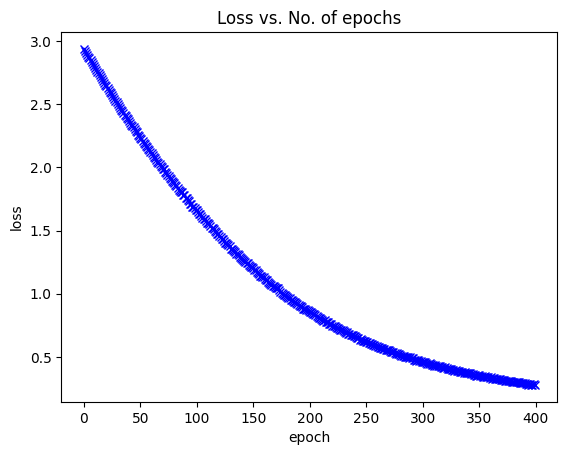

In [25]:
plot_losses(log)

In [38]:
print(train_data.classes)

['Berchtold_Marvelle3.20.23Rack1-11_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-14_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-7_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_7_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_9_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_10_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_16_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_21_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_22_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_23_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_24_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_25_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_26_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_27', 'Schwartz_Jodi3.21.23_lgorbitvu_29_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED', 'Vultaggio_Wesley3.16.23Rack2-24', 'Vultaggio_Wesley3.16.23Rack2-26', 'Vultaggio_Wesley3.16.23Rack2-4']


In [27]:
import numpy as np

In [29]:
np.savetxt('nombre_del_archivo.txt', train_data.classes, fmt='%s')

In [30]:
def predict(model,img,classes,device,to_device):
    x = to_device(img.unsqueeze(0),device)
    output = model(x)
    _,pred = torch.max(output,dim=1)
    return classes[pred[0].item()]

In [31]:
@torch.no_grad()
def evaluate(model,val_loader,output=False):
    model.eval()
    outputsBatch = []
    outputArray = {
      'predicted': [],
      'labels': [],
    }
    for batch in val_loader:
      images,labels= batch
      outputs=model(images)
      loss = F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, dim=1)
      correct = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
      outputsBatch.append({"error": loss.detach(),"acc": correct })
      if(output):
        outputArray['predicted'].extend(predicted.detach().cpu().numpy())
        outputArray['labels'].extend(labels.detach().cpu().data.numpy())
    if(output):
        resOuput = batch_results(outputsBatch)
        resOuput['outputs'] = outputArray
        return resOuput

In [32]:
test_dataset = datasets.ImageFolder('data/test', transform=train_transforms)
# Crear el iterador para recorrer los datos de prueba en lotes
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
TEST_DATA_DL = DeviceDataLoader(test_loader, device)

In [33]:
resultsTest = evaluate(model, TEST_DATA_DL, True)
print("Error:",resultsTest['error'], "Accuracy:",resultsTest['acc'])

Error: 1.7534223794937134 Accuracy: 0.6000000238418579


In [34]:
curretTimeStap = time.strftime("%Y%m%d-%H%M%S")
acurracy_round = str(round(100*resultsTest['acc'], 2))
DIR_MODEL = 'models/objectDetentation' + curretTimeStap + '['+acurracy_round+']' +'.pth'
torch.save(model.state_dict(), DIR_MODEL)

In [ ]:
MatrixScore(resultsTest['outputs']['labels'],resultsTest['outputs']['predicted'],CLASES)

In [226]:
len(test_dataset)

30

In [236]:
len(test_dataset.classes)

19

In [237]:
len(train_data.classes)

19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED , Predicted: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED


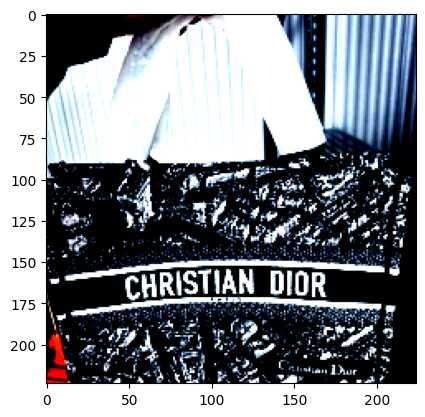

In [37]:
# test =test_dataset[0]
img1,label1= test_dataset[23]
plt.imshow(img1.permute(1, 2, 0))
print('Label:', test_dataset.classes[label1], ', Predicted:', predict(model,img1,test_dataset.classes,device,to_device))


In [24]:
load_model = models.shufflenet_v2_x1_0(pretrained=True)
# Congelar todas las capas del modelo pre-entrenado
for param in load_model.parameters():
    param.requires_grad = False

load_model.fc = nn.Linear(1024, num_classes)
load_model = to_device(load_model, device)

load_model.load_state_dict(torch.load('models/objectDetentation20230424-234701[63.33].pth'))
load_model.eval()

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED , Predicted: Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_7_BATCHED


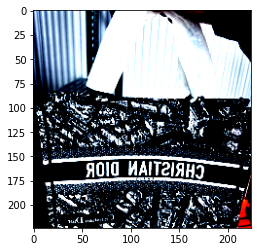

In [25]:
# test =test_dataset[0]
img1,label1= test_dataset[23]
plt.imshow(img1.permute(1, 2, 0))
print('Label:', test_dataset.classes[label1], ', Predicted:', predict(load_model,img1,test_dataset.classes,device,to_device))
